In [20]:


import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn

patch_sklearn()
from drowsiness_detection.visualize import plot_roc_over_sessions, plot_roc_over_subjects, plot_roc_over_n_folds
import pickle
import json
from copy import deepcopy
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
from sklearn.model_selection import train_test_split
from drowsiness_detection.data import (get_feature_data, preprocess_feature_data,
                                       session_type_mapping)
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.metrics import RocCurveDisplay
plt.rcParams["figure.figsize"] = 14, 7

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [24]:
def plot_roc_curve_from_log_dir(experiment_num=21, plot_train_roc: bool = False, ax=None, pos_label=0):
    if ax is None:
        fig, ax = plt.subplots()
    with open(f"../logs/{experiment_num}/config.json") as fp:
        exp_config = json.load(fp)
    window_size = exp_config["window_in_sec"]
    config.set_paths(30, window_size)

    # load hyperparameter results
    with open(f"../logs/{experiment_num}/best_model.pkl", "rb") as fp:
        best_estimator = pickle.load(fp)

    # load data
    data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
    X, y = preprocess_feature_data(feature_data=data,
                                   exclude_sess_type=session_type_mapping[exclude_by],
                                   num_targets=num_targets)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=seed)

    RocCurveDisplay.from_estimator(estimator=best_estimator, X=X_test, y=y_test, name=f"RF-{window_size}s" + ("(test)" if plot_train_roc else ""), ax=ax, pos_label=pos_label)
    if plot_train_roc:
        RocCurveDisplay.from_estimator(estimator=best_estimator, X=X_train, y=y_train, name=f"RF-{window_size}s(train)", ax=ax, pos_label=pos_label)

def plot_learning_curve_from_errors(train_errors, test_errors,          n_estimator_options,window_size: int, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(f"Learning Curve of Random Forest Classifier (window size {window_size} sec.)")
    ax.plot(n_estimator_options, train_errors, '-r', label="train")
    ax.plot(n_estimator_options, test_errors, '-g', label="test")
    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("Accuracy")
    _ = ax.legend()

def plot_learning_curve_from_log_dir(experiment_num, ax=None):
    # load hyperparameter results
    with open(f"../logs/{experiment_num}/search_result.pkl", "rb") as fp:
        search_result = pickle.load(fp)
    best_params = search_result.best_params_

    with open(f"../logs/{experiment_num}/config.json") as fp:
        exp_config = json.load(fp)
    window_size = exp_config["window_in_sec"]

    config.set_paths(30, window_size)


    data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
    X, y = preprocess_feature_data(feature_data=data,
                                   exclude_sess_type=session_type_mapping[exclude_by],
                                   num_targets=num_targets)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=seed)

    num_samples = -1

    scaler = search_result.estimator.named_steps['scaler']
    X_train_scaled = scaler.fit_transform(X_train, y_train)[:num_samples]
    X_test_scaled = scaler.transform(X_test)[:num_samples]

    warm_start_params = best_params.copy()
    warm_start_params['classifier__n_estimators'] = 1
    warm_start_params["classifier__warm_start"] = True
    warm_start_params['classifier__n_jobs'] = -2

    best_estimator = search_result.estimator.set_params(**warm_start_params)

    test_errors = []
    train_errors = []

    classifier = deepcopy(best_estimator.named_steps['classifier'])

    n_estimator_options = np.logspace(2, 9, num=10, base=2)
    for added_estimators in n_estimator_options:
        # print(f" number of estimators: old -> {classifier.n_estimators}, new: {int(added_estimators)}")
        classifier.n_estimators = int(added_estimators)

        classifier.fit(X_train_scaled, y_train[:num_samples])
        y_hat_train = classifier.predict(X_train_scaled)
        y_hat_test = classifier.predict(X_test_scaled)

        train_errors.append(accuracy_score(y_train[:num_samples], y_hat_train))
        test_errors.append(accuracy_score(y_test[:num_samples], y_hat_test))

    plot_learning_curve_from_errors(train_errors=train_errors, test_errors=test_errors,
                                n_estimator_options=n_estimator_options, window_size=window_size, ax=ax)

In [25]:
# fixed experiment params
seed = 123
test_size = .2
num_targets = 2
exclude_by = 'a'

EXPERIMENT_IDS = (21,23,25)

## Plot ROC Curve for all models

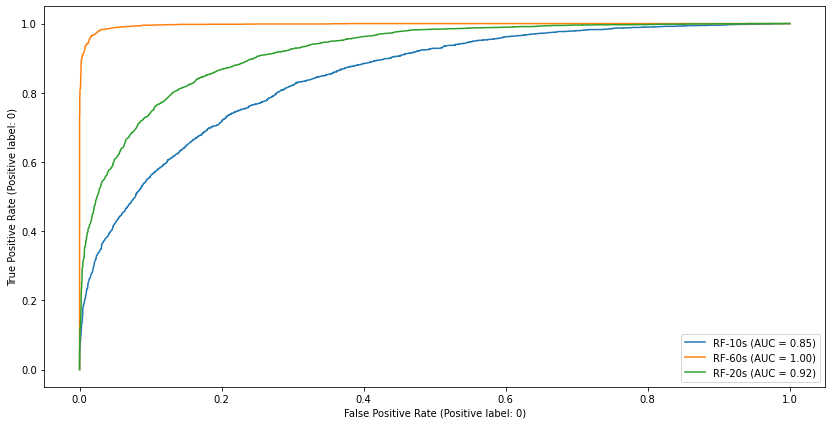

In [26]:
fig, ax = plt.subplots()

for experiment_num in EXPERIMENT_IDS:
    plot_roc_curve_from_log_dir(experiment_num=experiment_num, ax=ax)

### Plot learning curve for each model


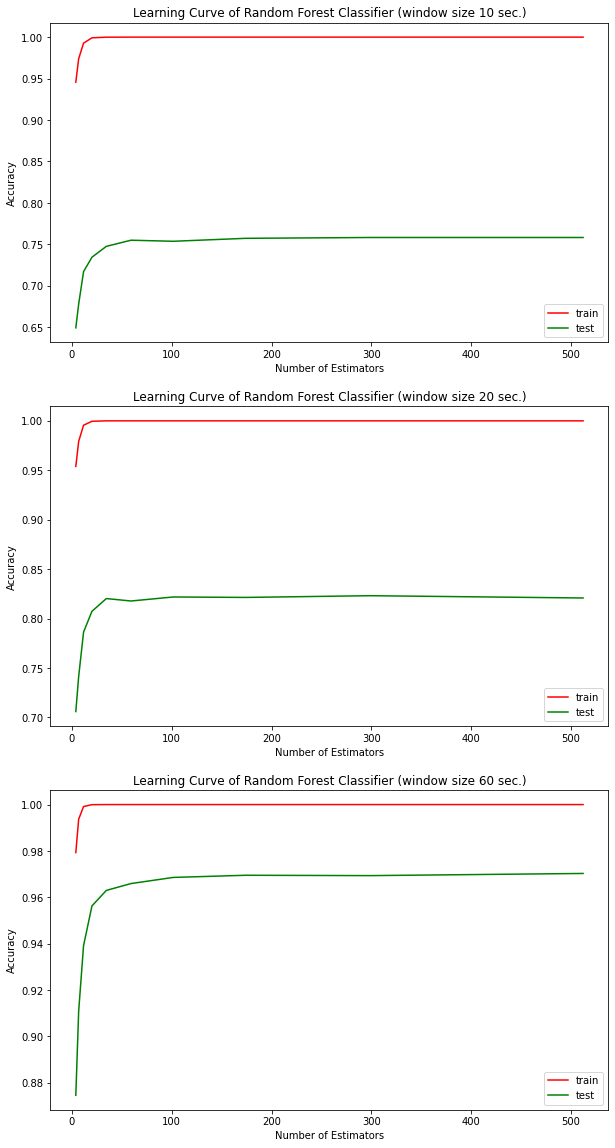

In [19]:
plt.rcParams["figure.figsize"] = 10, 20

fig, axes = plt.subplots(3,1)
for experiment_num, ax in zip((21, 25,23), axes):
    plot_learning_curve_from_log_dir(experiment_num=experiment_num, ax=ax)
